# Welcome to the project "Predicting Airbnb prices with machine learning". 

To make it easier to navigate through the code, let us first set the following naming conventions:

Class names: singular and capitalized (e.g.,  'Book' rather than 'book' or 'Books') <br/>
Multiple words in a name will be separated by an underscore. <br/>
Member functions: lowercase verbs (e.g., preprocess_data) <br/>
Variables: lowercase nouns (e.g., product_id) <br/>
Constant: uppercase nouns (e.g., MAX_SIZE) <br/>

# Setup
Let's first import the modules that we will need.

In [1]:
import pandas as pd
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import requests

from category_encoders import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns; 

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from yellowbrick.model_selection import RFECV
from sklearn.feature_selection import RFE

I downloaded the data from 'http://insideairbnb.com/get-the-data.html' on Sep. 2020, but you can easily access it from my GitHub by just a few lines of code.

In [2]:
import requests
import io

CSV_URL = 'https://github.com/mtorabirad/PricePrediction/blob/master/Tor/DetailedData/listings.csv'
response  = requests.get(CSV_URL).content
online_df = pd.read_csv(io.StringIO(response.decode('utf-8')), error_bad_lines=False, warn_bad_lines=False)
#print(online_df.head(1))

CSV_local_address = r"C:\DATA\Projects\PortFolioProjects\September2020\Tor\DetailedData\listings.csv"
num_lines = sum(1 for l in open(CSV_local_address, encoding='utf-8'))
n = 99
size = int(n*0.01*num_lines)
skip_idx = random.sample(range(1, num_lines), num_lines - size) # range form 1 to make sure header row is not skipped.
local_df = pd.read_csv(CSV_local_address, skiprows=skip_idx)

#print('len(online_df.index)', len(online_df.index))
#print('len(local_df.index)', len(local_df.index))
working_df = local_df

Next, we will define three classes: CleanData, ExploreData, PreprocessData. These classes, as their names suggest, implement methods for cleaning, exploring, and preprocessing data. Each class will provide a "public" interface to the "private" methods it impelements. <br/>

The three classes will be then inherited by another class (i.e., ObjectOrientedEDA) that will use those methods to perform object-oriented Exploratory Data Analysis.

In [3]:
class CleanData():

    def __init__(self):                
        """ Implements methods that will be used by a superclass to clean data.

            Public interface:
                replace_these_symbols_in_these_cols(replace_dic)
                standardize_letters_in_cat_cols()
                convert_the_type_of_these_cols(dic)
                drop_these_cols(dic)
                handleNaN()
            
        """
        print("CleanData object created")
    
    def replace_these_symbols_in_these_cols(self, replace_dic):
        self._replace_these_symbols_in_these_cols(replace_dic)  

    def standardize_letters_in_cat_cols(self):
        self._standardize_letters_in_cat_cols()      
    
    def convert_the_type_of_these_cols(self, dic):
        self._convert_the_type_of_these_cols(dic)

    def drop_these_cols(self, cols):
        self._drop_these_cols(cols)

    def handleNaN(self):
        self._handleNaN()
    
    # Private methods (abstracted out)
    def _replace_these_symbols_in_these_cols(self, replace_dic):        
        for col, symbols in replace_dic.items():
            try:        
                self.data[col] = self.data[col].str.replace(symbols[0], symbols[1])
            except:
                print('In col {}, {} cannot be replaced with {}'.format(col, symbols[0], symbols[1]))
               
    def _convert_the_type_of_these_cols(self, dic):
        for col, cast_to_type in dic.items():
            self.data[col] = self.data[col].astype(cast_to_type)

    def _standardize_letters_in_cat_cols(self):
        num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
        for column in self.data.columns:
            if self.data[column].dtypes not in num_types:
                #print(self.data[column].dtypes)
                self.data[column] = self.data[column].str.lower()

    def _drop_these_cols(self, cols):
        for column in cols:
            self.data=self.data.drop(labels=column, axis=1)
    
    def _handleNaN(self):
        #for col in cols:
        #    #self.data = self.data[pd.notnull(self.data[col])] 
        self.data = self.data.dropna(axis=0,how='all')
        num_cols = self.data.select_dtypes(exclude='object').columns
        cat_cols = self.data.select_dtypes(include='object').columns
        self.data[cat_cols] = self.data[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))
        self.data[num_cols] = self.data[num_cols].apply(lambda col: col.fillna(col.median()))

Our second class is ExploreData that implements functions responsible for exploring data (such as printing summary information or plotting). 

In [4]:
class ExploreData():

    def __init__(self):
        """
        This class will contain ALL the functions that may be used to explore data. At the moment, these include:
            print_summary_info()
            plot_histogram(cols)
        
        Other useful EDA methods: 
        df.describe() is useful for summarizing numeric data while df.value_counts() are good for categorical data.
        data.info()
        data.isnull().sum()
        sns.boxplot(x=data['Horsepower'])
        Before decising how to impute missing values, you should look at box plots. 
        For example, if the plot shows outliers, you should impute with median, not mean. For imputing, use 
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(strategy="median")imputer.fit(num_data)
        
        To look for the category distribution in categorical columns us data["CatCol"].value_counts()
        """
        print("Information object created")

    def print_summary_info(self, how_detailed=0, print_some_samples=False):
        """
        print feature name, data type, number of missing values and ten samples of 
        each feature
        :param data: dataset information will be gathered from
        :return: no return value
        """
        
        
        if how_detailed == 0:
            print("The dataset now has {} rows and {} columns .".format(*self.data.shape))
            #print(self.data.info(verbose=False))           
            print(self.data.columns.values)
        
        if how_detailed == 1:
            
            feature_dtypes=self.data.dtypes
            self.number_of_missing_values_for_each_col=self._get_number_of_missing_values_for_each_col(self.data)       
            # In the line below, instead of {:45} use the maximum # of characters in the feature names.
            print("{:45} {:21} {:21} {:21}".format("Feature Name".upper(), "Data Format".upper(), "# of Missing Values".upper(), "Samples".upper()))
            for feature_name, dtype, missing_value in zip(self.number_of_missing_values_for_each_col.index.values,
                                                        feature_dtypes[self.number_of_missing_values_for_each_col.index.values],
                                                        self.number_of_missing_values_for_each_col.values):
                print("{:48} {:21} {:21} ".format(feature_name, str(dtype), str(missing_value)), end="")
                if print_some_samples:
                    for v in self.data[feature_name].values[:3]:
                        print(v, end=",")
                print()            
        print("=" * 150)
    
    def plot_histogram(self, cols):
        
        if not os.path.exists(os.getcwd() + '/Figures'):
            os.makedirs(os.getcwd() + '/Figures')

        for col in cols:
            print('col=', col)
            _, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    
            axs.hist(self.data[col])
            #axs.set_xticks([0, 100, 200])
            axs.set_xlabel('price values')

            axs.set_ylabel('frequency')
            address_and_name = os.getcwd() + '/Figures/Histogram' + str(col)
            plt.savefig(address_and_name)
    
    def _get_number_of_missing_values_for_each_col(self,data):
        """
        Find missing values of given datad
        :param data: checked its missing value
        :return: Pandas Series object
        """
        #Getting sum of missing values for each feature
        missing_values = data.isnull().sum()
        print('missing_values=', missing_values)
        #Feature missing values are sorted from few to many
        
        missing_values.sort_values(ascending=False, inplace=True)
        
        #Returning missing values
        return missing_values

And now the class that implements functions responsible for preprocessing data (such as encoding categorical columns or scaling data).

In [5]:
class PreprocessData():    
    def __init__(self, data):
        """
        This class will contain ALL the functions that may be used to preprocess data. At the moment, these include:
            encode_then_delete_these_cat_cols(cols)
            scale_these_cols(cols)

        """
        print("FeatureEngineering object created")
    
    def encode_then_delete_these_cat_cols(self, cols):
        self._encode_then_delete_these_cat_cols(cols)

    def scale_these_cols(self, cols, method):
        self._scale_these_cols(cols, method)

    def _scale_these_cols(self, cols, method):
        #self.data['price'] = MinMaxScaler().fit_transform(self.data[['price']]) #Two brackets because MinMaxScalar can accept a pandas dataframe but not a series
        '''Function to scale the features
        Normalization: 
            Subtract the min, and divide by max - min, such that all the features end up ranging between 0 and 1.
            Recommended when the distribution is NOT Gaussian. 

        Standardization: S
            Subtract the mean and divide by standard deviation, such that the mean and std 
            of the scaled features are 0 and 1, respectivelly.
            Recommended when the distribution is Gaussian. 

        Input:
            df: df to be scaled - all the columns should be integer or float values. 
        '''        
        for col in cols:
            self.data[col] = MinMaxScaler().fit_transform(self.data[[col]])
        
    def _encode_then_delete_these_cat_cols(self, cols):
        """ Use binary encoding to encode two categorical features
        For a list of encoders: https://contrib.scikit-learn.org/category_encoders/

        OrdinalEncoder: Encodes categorical features as ordinal, in one ordered feature.
        OneHotEncoder: Onehot (or dummy) coding for categorical features, produces one feature per category, each binary.
        BinaryEncoder: Binary encoding for categorical variables, similar to onehot, but stores categories as binary bitstrings. """
        
        # Problem: How to assign Labels with Sklearn category_encoders?
        # Right now, only OneHotEncoder can include the category values in the encoded column names (use_cat_names=True)
        # In the link below, OneHotEncoder of sklearn.preprocessing (not category_encoders) 
        # is extended to allow using catagorical variables to label the columns
        # https://towardsdatascience.com/how-to-assign-labels-with-sklearn-one-hot-encoder-e59a5f17df4f
        # Is it possible to do a similar thing on the OneHotEncoder of the category_encoders?

        #encoder = OrdinalEncoder()
        #encoder = OneHotEncoder(use_cat_names=True) 
        #return pd.concat([df, encoder.fit_transform(df[column])],axis=1)
        for col in cols:
            self.data = pd.concat([self.data, pd.get_dummies(self.data[col], prefix=col)],axis=1)
            self.data = self.data.drop(columns = col)
        # The next three lines should not be in this method. They are not related to encoding. 
        #numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
        #self.data = self.data.select_dtypes(include=numerics)
        #self.data = self.data.dropna(axis=1, how='all')

Now the the class that inherits from the above three base classes.

In [6]:
class ObjectOrientedEDA(ExploreData, CleanData, PreprocessData):
    """
        This class will cleate the data object and invoke the methods implemented in classes ExploreData, CleanData, and PreprocessData.
        The methods of this class ONLY can be invoked from the main. 

    """
    def __init__(self, data1, data2=None):        
        self.train=data1
        self.test=data2
        self.data=self._concat_two_datasets()
        #print("ObjectOrientedTitanic object created")

    def print_summary_info(self, how_detailed=0, print_some_samples=False):             
        super(ObjectOrientedEDA, self).print_summary_info(how_detailed)
    
    def plot_histogram_of_this_column(self, col):
        super(ObjectOrientedEDA, self).plot_histogram([col])
    
    def clean_data(self, select_these_cols):
        # Drop any col that has url in it
        cols_with_url = []
        for col in self.data.columns:
            if 'url' in col:
                cols_with_url.append(col)
        #print(cols_with_url)
        super(ObjectOrientedEDA, self).drop_these_cols(cols_with_url + ['host_name', 'host_id', 
                                                        'id', 'name', 'neighbourhood', 'last_review', 
                                                        'calculated_host_listings_count', 'reviews_per_month', 
                                                        'minimum_nights', 'availability_365', 'number_of_reviews', 'city', 'state', 'country_code',
                                                        'country'])
        
        # Define a replacement dictionary like this: {'$':'', ',':'', ' ':''} and a colum list
        # Pass list of cols and the replacement dictionary
        #['price', 'weekly_price', 'monthly_price', 'extra_people', 'security_deposit', 'cleaning_fee']
        # Perhaps, something similar to this: self.data.host_is_superhost = self.data.host_is_superhost.map(dict(t=1, f=0))
        # Also, think about taking advantage of the fact that functions are object so you can make 
        # a list of the operations you want to apply and then invoke them in a for loop by "for function in function_operations":
        # For more details, see page 72 of Python for Data Analysis (second edition)
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'price': ['$', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'price': [',', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'price': [' ', '']})
        # Will using a composite ditionary help here? directory[last,first] = number

        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'weekly_price': ['$', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'weekly_price': [',', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'weekly_price': [' ', '']})

        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'monthly_price': ['$', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'monthly_price': [',', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'monthly_price': [' ', '']})

        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'extra_people': ['$', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'extra_people': [',', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'extra_people': [' ', '']})

        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'security_deposit': ['$', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'security_deposit': [',', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'security_deposit': [' ', '']})

        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'cleaning_fee': ['$', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'cleaning_fee': [',', '']})
        super(ObjectOrientedEDA, self).replace_these_symbols_in_these_cols({'cleaning_fee': [' ', '']})

        super(ObjectOrientedEDA, self).convert_the_type_of_these_cols({'price': 'float32'})
        #self.data = self.data[self.data['price'] < 1000] # This really helps with the r2 score! 
        super(ObjectOrientedEDA, self).convert_the_type_of_these_cols({'cleaning_fee': 'float32'})
        super(ObjectOrientedEDA, self).convert_the_type_of_these_cols({'extra_people': 'float32'})
        super(ObjectOrientedEDA, self).convert_the_type_of_these_cols({'security_deposit': 'float32'})
        
        super(ObjectOrientedEDA, self).standardize_letters_in_cat_cols()
        super(ObjectOrientedEDA, self).handleNaN()

        # Drop all the cols except:
        '''
        selected_features  = ['cancellation_policy', 'is_location_exact', 'accommodates', 'property_type', 'price', 
        'host_total_listings_count', 'extra_people', 'guests_included', 'review_scores_rating', 'host_response_time',
        'host_is_superhost', 'room_type', 'instant_bookable', 'host_identity_verified', 'host_has_profile_pic',
        'security_deposit', 'host_listings_count', 'requires_license', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed',
        'bathrooms', 'require_guest_phone_verification', 'cleaning_fee']
        '''
        '''
        select_these_cols  = ['price', 'room_type', 'accommodates', 'bathrooms', 'cleaning_fee', 
                            'cancellation_policy', 'property_type', 'extra_people']
        '''
        self.data = self.data[select_these_cols]

    def preprocess_data(self):
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['room_type'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['cancellation_policy'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['property_type'])

        """super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['is_location_exact'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['host_response_time'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['neighbourhood_cleansed'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['host_is_superhost'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['host_identity_verified'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['host_has_profile_pic'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['requires_license'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['require_guest_phone_verification'])
        super(ObjectOrientedEDA, self).encode_then_delete_these_cat_cols(['instant_bookable']) """

        #self.data.host_is_superhost = self.data.host_is_superhost.map(dict(t=1, f=0))
        
        super(ObjectOrientedEDA, self).scale_these_cols(['price'], 'Normalization')
        super(ObjectOrientedEDA, self).scale_these_cols(['accommodates'], 'Normalization')
        super(ObjectOrientedEDA, self).scale_these_cols(['bathrooms'], 'Normalization')
        super(ObjectOrientedEDA, self).scale_these_cols(['cleaning_fee'], 'Normalization')
        super(ObjectOrientedEDA, self).scale_these_cols(['extra_people'], 'Normalization')
        
    def _concat_two_datasets(self):
        return pd.concat([self.train, self.test])

All the methods that we need for EDA are now implemented so we are ready to explore data. <br/>

We start by performing a very high-level EDA to get things like the name and number of rows and features. In general, such an initial high-level EDA is important because some datasets contain hundreds of features, most of which are not interesting for the business problem at hand, and should, therefore, be dropped. For example, in predicting Airbnb prices we can safely drop columns containing URL.

In [7]:
objectOrientedEDA=ObjectOrientedEDA(working_df) 
objectOrientedEDA.print_summary_info(how_detailed=0)

The dataset now has 20946 rows and 106 columns .
['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' '

The data has more than 20000/100 rows/features. It contains information about ....

Let's do slightly more detailed EDA by changing the argument 'how_detailed' from 0 to 1.

In [8]:
objectOrientedEDA.print_summary_info(how_detailed=1, print_some_samples=False)

missing_values= id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               1
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               4191
Length: 106, dtype: int64
FEATURE NAME                                  DATA FORMAT           # OF MISSING VALUES   SAMPLES              
neighbourhood_group_cleansed                     float64               20946                 
thumbnail_url                                    float64               20946                 
xl_picture_url                                   float64               2094

Some of the columns are full of missing values. Some columns, for example those containing URLs, are not interesting at least for price prediction. So let's select only the interesting columns and clean the data.

In [9]:
keep_these_cols  = ['price', 'room_type', 'accommodates', 'bathrooms', 'cleaning_fee', 'cancellation_policy', 'property_type', 'extra_people','square_feet', 'monthly_price', 'weekly_price']
objectOrientedEDA.clean_data(keep_these_cols)

Note that the method clean_data will, in addition to dropping non-interesting columns, perform under the hood operations like dropping $ sign, handling NaN values, standardizing strings. <br/>

Now that the data is cleaned up, pandas built-in methods such as describe and hist will give a nicely formatted output. 

In [10]:
objectOrientedEDA.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20946 entries, 0 to 20945
Data columns (total 11 columns):
price                  20946 non-null float32
room_type              20946 non-null object
accommodates           20946 non-null int64
bathrooms              20946 non-null float64
cleaning_fee           20946 non-null float32
cancellation_policy    20946 non-null object
property_type          20946 non-null object
extra_people           20946 non-null float32
square_feet            20946 non-null float64
monthly_price          20946 non-null object
weekly_price           20946 non-null object
dtypes: float32(3), float64(2), int64(1), object(5)
memory usage: 1.7+ MB


In [11]:
objectOrientedEDA.data.describe()

,price,accommodates,bathrooms,cleaning_fee,extra_people,square_feet
count,20946.000000,20946.000000,20946.000000,20946.000000,20946.000000,20946.000000
mean,142.698029,3.122410,1.255801,60.127327,13.524539,3.675260
std,272.474396,2.077355,0.565644,47.699978,24.945578,136.827176
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,64.000000,2.000000,1.000000,30.000000,0.000000,0.000000
50%,100.000000,2.000000,1.000000,50.000000,0.000000,0.000000
75%,150.000000,4.000000,1.000000,75.000000,20.000000,0.000000
max,13419.000000,18.000000,10.000000,990.000000,430.000000,16146.000000


Note that while 75% of prices are below 150, the maximum price is above $13000! We should exclude such extreme values. 

In [12]:
objectOrientedEDA.data = objectOrientedEDA.data[objectOrientedEDA.data['price'] < 1000]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC2BE4B160>,
      dtype=object)

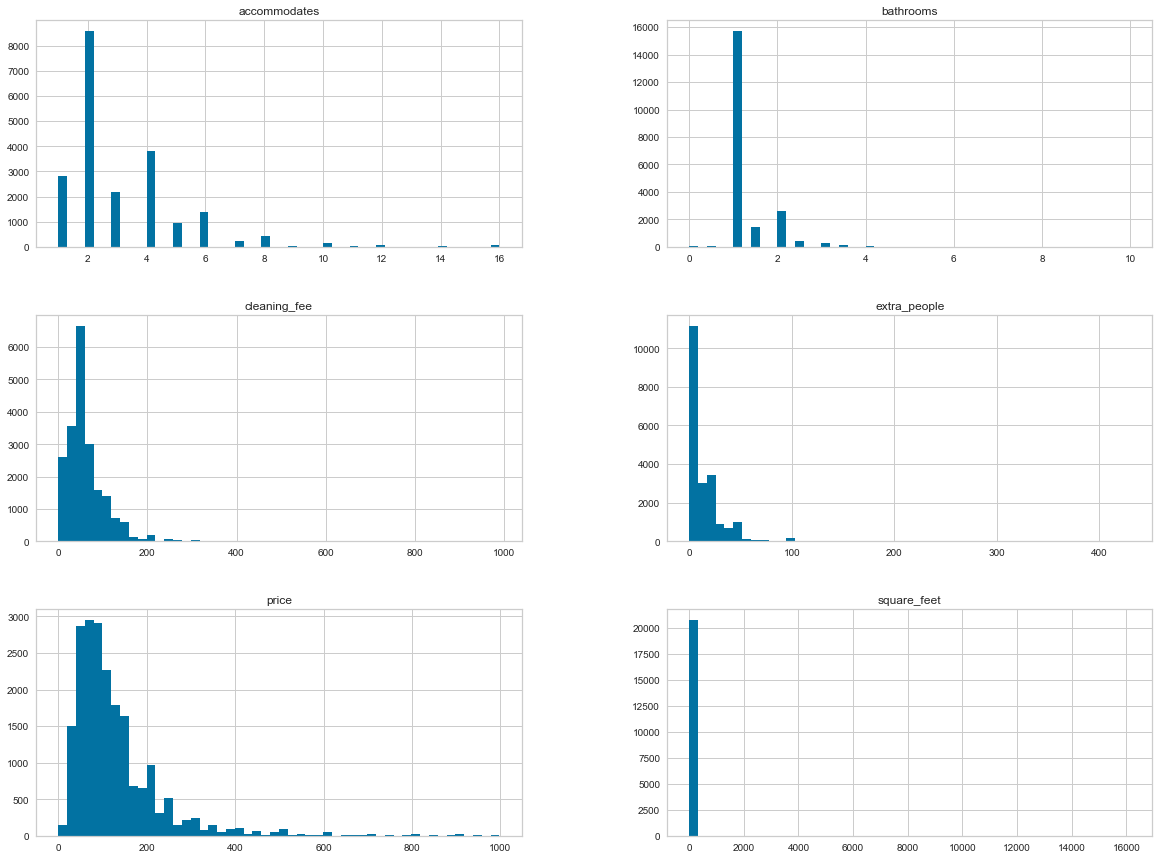

In [13]:
objectOrientedEDA.data.hist(bins=50, figsize=(20,15))

### Multicollinearity diagnostics 
The first step in multicollinearity diagnostics is looking at the pairwise correlations coefficients. 

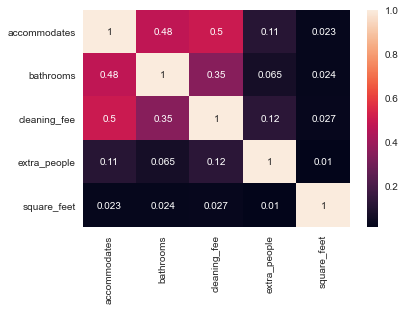

In [14]:
tmp_df = objectOrientedEDA.data.loc[:, objectOrientedEDA.data.columns != 'price']
corr_matrix = objectOrientedEDA.data.loc[:, objectOrientedEDA.data.columns != 'price'].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
#sns.pairplot(objectOrientedEDA.data[['cleaning_fee', 'accommodates', 'bathrooms']])

As you can see, the highest collinearity is between 'accommodates' and 'cleaning_fee' (0.5) and then between 'accommodates' and 'bathrooms' (0.47)<br/n>. These values are not too high, but if they were, we would have had to do a more through diagnostics by looking at the Variance Inflation Factors (VIF).



### Heteroscedasticity diagnostics 
The most basic (informal) way heteroscedasticity diagnostics is to plot the least squares residuals vs the explanatory variable. If there is an evident pattern in the plot, then heteroskedasticity is present. <br\n>

https://towardsdatascience.com/assumptions-of-linear-regression-algorithm-ed9ea32224e1


There are more formal ways of detecting heteroscedasticity, such as White and Breusch-Pagan tests, but we will skip them for now and look at only residual plots.

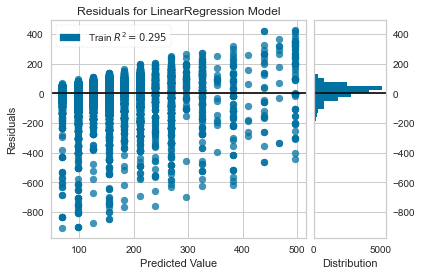

In [31]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
Lr = LinearRegression()
visualizer = ResidualsPlot(Lr)
#series = objectOrientedEDA.data[['price']].iloc[:,0]
feature_tmp = objectOrientedEDA.data[['accommodates']].to_numpy().reshape(-1, 1)
target_tmp = objectOrientedEDA.data[['price']].to_numpy().reshape(-1, 1)

visualizer.fit(feature_tmp, target_tmp, )
visualizer.show()